In [1]:
import os
import sys 

parent_directory = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(parent_directory)  # this allows for the pipeline to be imported 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pipeline import clean_text
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/ray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ray/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ray/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/ray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ray/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
def addPath(folder_name, list):
    parent_directory = os.path.dirname(os.path.abspath(os.getcwd()))
    folder = os.path.join(parent_directory, folder_name)
    return [os.path.join(folder, i) for i in list]  


example_datsets = ["Unbalanced_news.csv", "unbalanced_tweets.csv"]

datasets = addPath("Datasets", example_datsets)

news = pd.read_csv(datasets[0])
tweets = pd.read_csv(datasets[1])

fake_news = news[news["labels"] == 0]
true_news = news[news["labels"] == 1]

fake_tweets = tweets[tweets["labels"] == 0]
true_tweets = tweets[tweets["labels"] == 1]

In [ ]:
df_sets = [("Fake news",fake_news), ("Fake tweets",fake_tweets), ("True News", true_news), ("True tweets", true_tweets)]

In [ ]:
def get_word_corspe(df):
    text = ""
    for _, row in df.iterrows():
        text+=clean_text(row["data"])
    
    return text

fake_news_corspe = get_word_corspe(fake_news)
fake_tweets_corspe = get_word_corspe(fake_tweets)
true_news_corspe = get_word_corspe(true_news)
true_tweets_corspe = get_word_corspe(true_tweets)


In [ ]:
wordclouds = [ (name, WordCloud(max_font_size=60).generate(value)) for name, value in [("Fake news",fake_news_corspe), ("Fake tweets",fake_tweets_corspe), ("True News", true_news_corspe), ("True tweets", true_tweets_corspe)]]

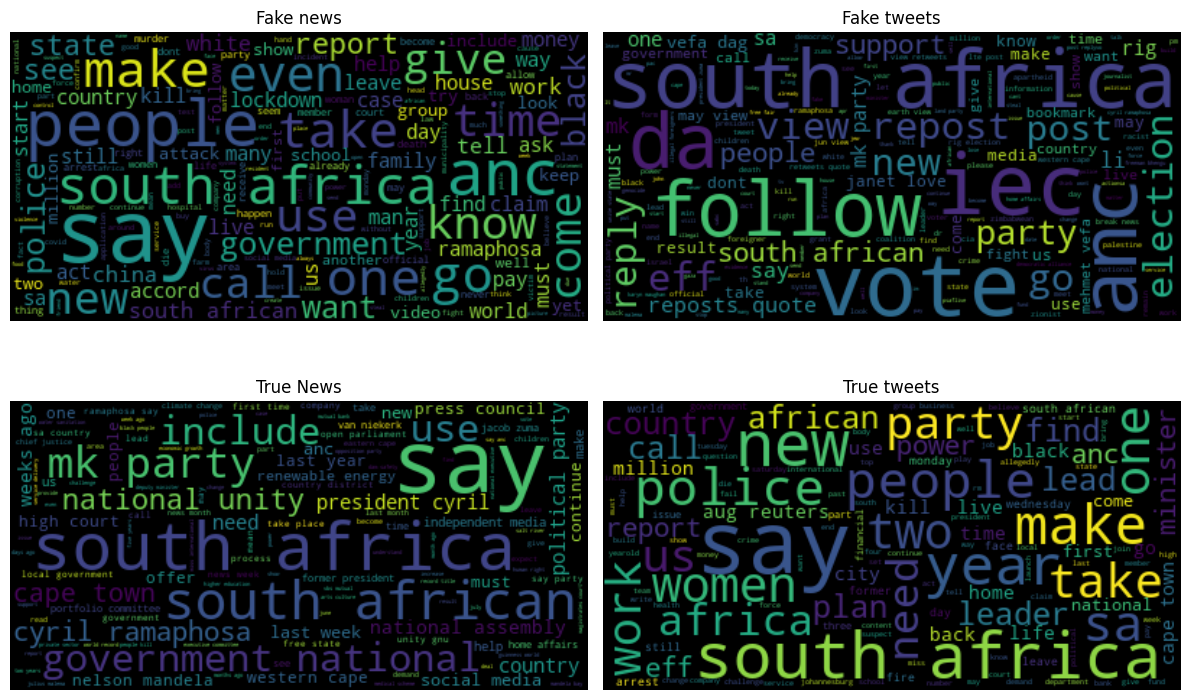

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(wordclouds[i][1], interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"{wordclouds[i][0]}")

plt.tight_layout()
plt.savefig("WordClouds.png")
plt.show()

## Word counts 

In [ ]:
def get_count(df):
    data = df["data"].apply(lambda x: clean_text(x, tweet=True))
    return data.str.findall(r"(\w+)").explode().value_counts()

all_counts= [get_count(i[1]).nlargest(30) for i in df_sets]

In [ ]:


def save_as_one(counts):
    fig, axes = plt.subplots(2, 2, figsize=(15, 11))

    for i, ax in enumerate(axes.flat):
        sns.barplot(x=counts[i].index, y=counts[i].values, ax=ax)
        ax.set_title(f"{df_sets[i][0]}")
        ax.set_ylabel('Number of Occurrences', fontsize=12)
        ax.set_xlabel('Word', fontsize=12)
        ax.xaxis.set_tick_params(rotation=90)


    plt.tight_layout()
    plt.savefig("WordCounts.png")
    plt.show()

def save_individual(counts):
    for i in range(len(counts)):
        plt.figure(figsize=(10, 6))  # Set figure size for better visibility
        sns.barplot(x=counts[i].index, y=counts[i].values)
        plt.title(f"{df_sets[i][0]}", fontsize=16)  # Increased title font size
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel('Word', fontsize=12)
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.savefig(f'{df_sets[i][0]}.png')
        plt.close()  # Close the figure to free memory

save_individual(all_counts)


## Sentement Analysis 

### VADER 

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()

def getPolarity(df):
    labelled_sentiment_scores = []
    for i in df:
        score = analyzer.polarity_scores(clean_text(i, tweet=True))
        if score["neg"] >  score["pos"]:
            labelled_sentiment_scores.append("Negative")
        else:
              labelled_sentiment_scores.append("Positive")
    return labelled_sentiment_scores



sentFilter = lambda x, y: [i for i in y if i == x]

def divdePoliarity(data):
    postive = len(list(sentFilter("Positive", data)))
    negative = len(list(sentFilter("Negative", data)))
    #neutral = len(list(sentFilter("Neutral", data)))
    return pd.DataFrame(zip([postive, negative], ["Positive", "Negative"]), columns=["count", "Sentiment"])

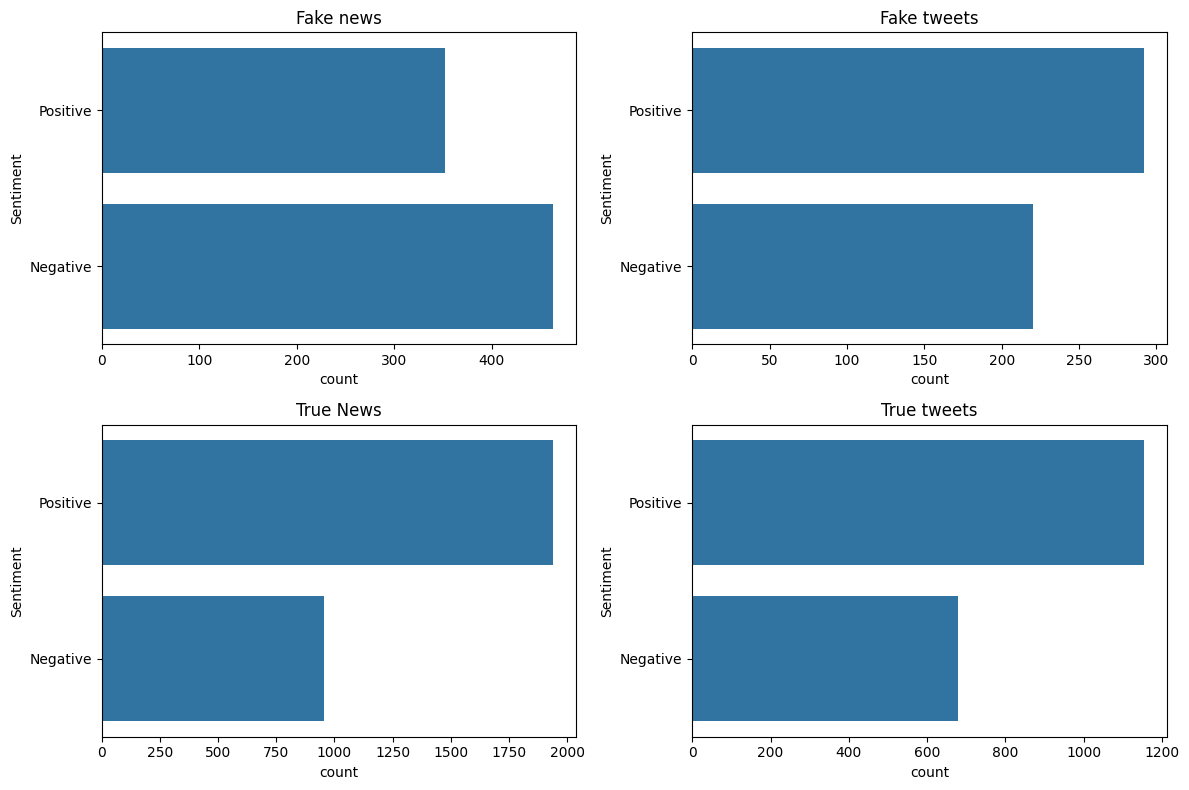

In [ ]:

polority = [getPolarity(i[1]["data"]) for i in df_sets]

frames = [divdePoliarity(i) for i in polority]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    sns.barplot(frames[i], x="count", y="Sentiment", ax=ax)
    ax.set_title(f"{df_sets[i][0]}")

plt.tight_layout()
plt.savefig("Seniment.png")
plt.show()


### Transformer


@article{hartmann2023,
title = {More than a Feeling: Accuracy and Application of Sentiment Analysis},
journal = {International Journal of Research in Marketing},
volume = {40},
number = {1},
pages = {75-87},
year = {2023},
doi = {https://doi.org/10.1016/j.ijresmar.2022.05.005},
url = {https://www.sciencedirect.com/science/article/pii/S0167811622000477},
author = {Jochen Hartmann and Mark Heitmann and Christian Siebert and Christina Schamp},
}


## Statistical Summary 

In [ ]:
# looking at Token count 
print("Tokens")
df_len = [i[1]["data"].apply(len)  for i in df_sets]#lambda x: x["data"].apply(len)

desc = [i.describe() for i in df_len]

for i in range(4):
    print(f'{df_sets[i][0]}')
    print(desc[i])

Tokens
Fake news
count      815.000000
mean      2348.801227
std       1984.100602
min        121.000000
25%       1033.000000
50%       1677.000000
75%       3022.000000
max      14185.000000
Name: data, dtype: float64
Fake tweets
count     512.000000
mean      470.429688
std       491.917239
min         2.000000
25%       263.750000
50%       364.500000
75%       510.500000
max      4820.000000
Name: data, dtype: float64
True News
count     2895.000000
mean      3439.827634
std       2019.494671
min        138.000000
25%       2128.000000
50%       3131.000000
75%       4374.500000
max      20462.000000
Name: data, dtype: float64
True tweets
count    1832.000000
mean      182.838428
std        73.154917
min        23.000000
25%       129.750000
50%       176.000000
75%       228.000000
max       948.000000
Name: data, dtype: float64


In [ ]:
# sentence count 
print("sentences")
df_len = [i[1]["data"].apply(lambda x: len(x.split(" ")))  for i in df_sets]#lambda x: x["data"].apply(len)

desc = [i.describe() for i in df_len]

for i in range(4):
    print(f'{df_sets[i][0]}')
    print(desc[i])

sentences
Fake news
count     815.000000
mean      396.965644
std       335.327851
min        20.000000
25%       174.500000
50%       283.000000
75%       509.000000
max      2410.000000
Name: data, dtype: float64
Fake tweets
count    512.000000
mean      57.650391
std       67.871561
min        1.000000
25%       29.000000
50%       44.000000
75%       61.000000
max      694.000000
Name: data, dtype: float64
True News
count    2895.000000
mean      559.897755
std       317.675970
min        27.000000
25%       355.000000
50%       504.000000
75%       701.000000
max      3127.000000
Name: data, dtype: float64
True tweets
count    1832.000000
mean       25.903930
std        11.816573
min         1.000000
25%        18.000000
50%        24.000000
75%        33.000000
max       156.000000
Name: data, dtype: float64
